# Airline On-Time Performance Data Exploratory Analysis
## by Esosa Orumwese

## Investigation Overview

The goal of this investigation was to generate insights from 2007 airline on-time performance data which revolves around
1. Were there more delayed flights than there were early or on-time flights?
1. How does the number of registered flights vary per month?
2. What is the distribution of early, on-time, delayed and cancelled flights per month?
3. What is the distribution of daily flight cancellations?
4. How does the number of registered flights compare amongst airlines?
5. What is the distribution of delays for the top airlines?

## Dataset Overview

The dataset used consists of flight arrival and departure details for all commercial flights within the USA in 2007. It is a large dataset with nearly 7.5 million records, 25 variables, and takes up 1.2 gigabytes of space. The data comes originally from RITA where it is described in detail.

In [1]:
# import modules and libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calplot
import math # for .floor and .ceil

# suppressing SettingWithCopyWarning
pd.options.mode.chained_assignment = None # default='warn'

pd.set_option('display.max.columns', 500)
plt.style.use('seaborn-dark-palette')
%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
airline_df = pd.read_csv('airline_clean.csv')
airports = pd.read_csv('airports.csv')
planes_data = pd.read_csv('plane_clean.csv')
carriers = pd.read_csv('carriers.csv')

In [3]:
airline_df['Date'] = pd.to_datetime(airline_df['Date'])

In [4]:
cat_cols = ['UniqueCarrier', 'FlightNum', 'Origin', 'Dest']

for col in cat_cols:
      airline_df[col] = airline_df[col].astype('category')

In [5]:
# dataset overview
airline_df.head(10)

,Date,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2007-01-01,1232.0,1225,1341.0,1340,WN,2891,1.0,7.0,SMF,ONT,389,4,11,False,NaN,False,0,0,0,0,0
1,2007-01-01,1918.0,1905,2043.0,2035,WN,462,8.0,13.0,SMF,PDX,479,5,6,False,NaN,False,0,0,0,0,0
2,2007-01-01,2206.0,2130,2334.0,2300,WN,1229,34.0,36.0,SMF,PDX,479,6,9,False,NaN,False,3,0,0,0,31
3,2007-01-01,1230.0,1200,1356.0,1330,WN,1355,26.0,30.0,SMF,PDX,479,3,8,False,NaN,False,23,0,0,0,3
4,2007-01-01,831.0,830,957.0,1000,WN,2278,-3.0,1.0,SMF,PDX,479,3,9,False,NaN,False,0,0,0,0,0
5,2007-01-01,1430.0,1420,1553.0,1550,WN,2386,3.0,10.0,SMF,PDX,479,2,7,False,NaN,False,0,0,0,0,0
6,2007-01-01,1936.0,1840,2217.0,2130,WN,409,47.0,56.0,SMF,PHX,647,5,7,False,NaN,False,46,0,0,0,1
7,2007-01-01,944.0,935,1223.0,1225,WN,1131,-2.0,9.0,SMF,PHX,647,4,9,False,NaN,False,0,0,0,0,0
8,2007-01-01,1537.0,1450,1819.0,1735,WN,1212,44.0,47.0,SMF,PHX,647,5,7,False,NaN,False,20,0,0,0,24
9,2007-01-01,1318.0,1315,1603.0,1610,WN,2456,-7.0,3.0,SMF,PHX,647,5,8,False,NaN,False,0,0,0,0,0


## Were there more delayed flights than there were early or on-time flights?
The dataset contained a lot of negative values, signifying the flights that were early. As a result, departure delay was grouped into 4 categories;
* OnTime_Early: Delay times that were less than or equal zero,
* Small_Delay: Delay time of less than 15 minutes,
* Medium_Delay: Delay times between 15 minutes and 45 minutes,
* Large_Delay: Delay times greater than 45 minutes.

It was found that 55% of the flights in 2007 were either on-time or early with just 21.95% experiencing a small delay and 2% cancelled.

In [7]:
# getting color to use in plots
base_color = sns.color_palette()[5]

In [8]:
# creating new column to hold group
airline_df['DelayGroup'] = None

# filling column with values based on delay duration
airline_df.loc[airline_df['DepDelay'] <= 0, 'DelayGroup'] = "OnTime_Early"
airline_df.loc[(airline_df['DepDelay'] > 0) & (airline_df['DepDelay'] <= 15), 'DelayGroup'] = "Small_Delay"
airline_df.loc[(airline_df['DepDelay'] > 15) & (airline_df['DepDelay'] <= 45), 'DelayGroup'] = "Medium_Delay"
airline_df.loc[airline_df['DepDelay'] > 45, 'DelayGroup'] = "Large_Delay"
airline_df.loc[airline_df['Cancelled'], 'DelayGroup'] = "Cancelled"

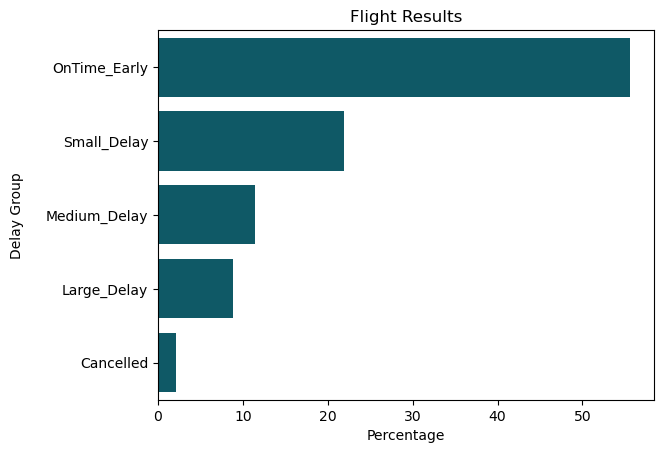

In [9]:
# plot data
plotdata = airline_df.DelayGroup.value_counts(normalize=True)
plotdata *= 100

sns.barplot(y=plotdata.index, x=plotdata.values, 
            color=base_color)
plt.title('Flight Results')
plt.xlabel('Percentage')
plt.ylabel('Delay Group\n')

plt.show();

## How does the number of registered flights vary per month?

Although the median number of bookings seems to be above 600,000 in 2007, February seemed to have the least amount of flight bookings (565,604) while July and August had the most (648,544 and 653,276 respectively).

In [10]:
# get the first 3 letters of the month name for each date
airline_df['Month'] = airline_df['Date'].dt.month_name().str.slice(stop=3)

month = airline_df.Month.unique()
monthClass = pd.api.types.CategoricalDtype(categories=month, ordered=True)
airline_df['Month'] = airline_df['Month'].astype(monthClass)

In [11]:
# create plotdata
plotdata = airline_df.groupby('Month')["Date"].count()

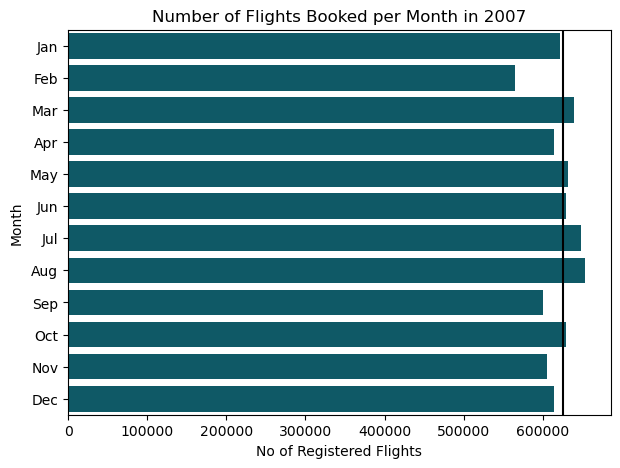

In [12]:
# bar plot
plt.figure(figsize=[7,5])
sns.barplot(y=plotdata.index, x=plotdata.values,
            color=base_color)
plt.xlabel('No of Registered Flights')
plt.axvline(x=plotdata.median(), color='black')
plt.title('Number of Flights Booked per Month in 2007')

plt.show();

## What is the distribution of early, on-time, delayed and cancelled flights per month?

There is clear and gradual decrease in percentage of delays for each month as seen in the heatmap below. 

In [13]:
# normalize=True, gets the proportion of each value by the row.
airline_df_agg = airline_df.groupby('Month')['DelayGroup'].value_counts(normalize=True).unstack()

# sorting columns
airline_df_agg = airline_df_agg[['OnTime_Early', 'Small_Delay', 'Medium_Delay',
                                 'Large_Delay', 'Cancelled']]

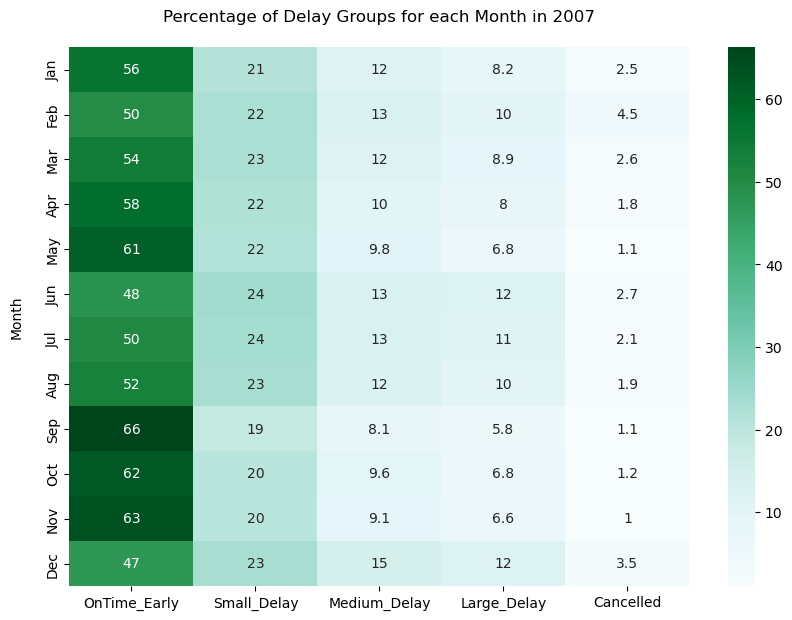

In [14]:
plt.figure(figsize=[10,7])
sns.heatmap((airline_df_agg*100), cmap='BuGn', annot=True)
plt.title('Percentage of Delay Groups for each Month in 2007\n')
plt.xlabel('')
plt.ylabel('Month\n')

plt.show();

When looking at the distribution, neglecting the on-time and early flights, we can notice that most delays occurred between June, July, August and December while September to November had the highest percentage of on time flights. February then December saw the highest percentage of cancelled flights than all other months in 2007.

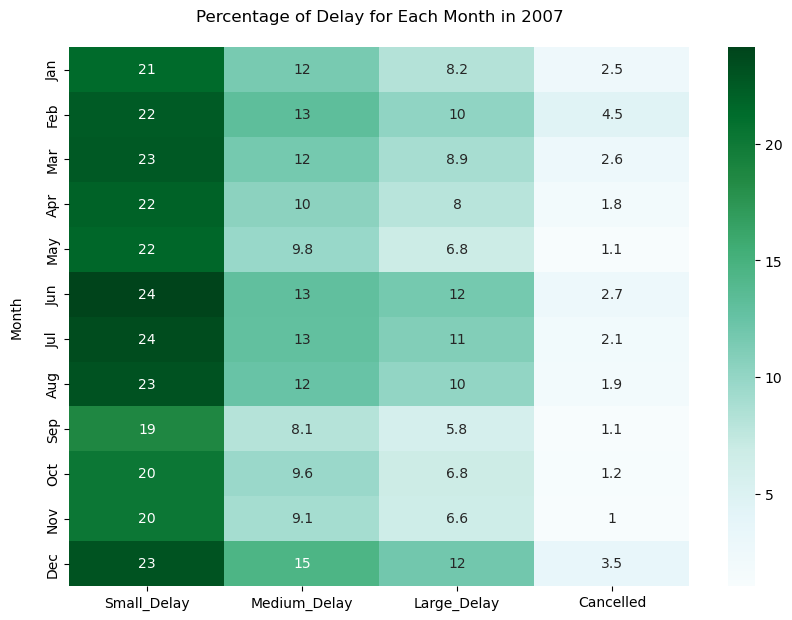

In [15]:
plt.figure(figsize=[10,7])
sns.heatmap((airline_df_agg.drop('OnTime_Early', axis=1)*100), 
            cmap='BuGn', annot=True)
plt.title('Percentage of Delay for Each Month in 2007\n')
plt.xlabel('')
plt.ylabel('Month\n')

plt.show();

## What is the distribution of daily flight cancellations like?

When plotting the log transform of the right skewed daily flight cancellations on a calendar plot, we can see basically 3 periods of increase in cancellations. From January to mid-April, then from June to August and from the last week of November to December.

In [16]:
# get the daily number of cancelled flights.
# remember True=1 and False=0
cancelled_per_day = airline_df.groupby('Date')['Cancelled'].sum()

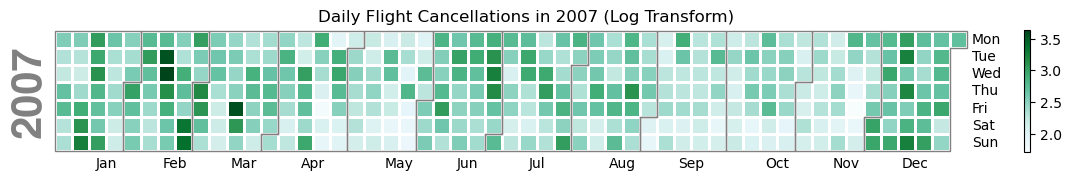

In [17]:
# plot
calplot.calplot(np.log10(cancelled_per_day), cmap='BuGn', colorbar=True,
                suptitle='Daily Flight Cancellations in 2007 (Log Transform)')

plt.show();

## How does the number of registered flights compare amongst airlines?

Southwest Airlines Co. seems to be the most popular airline in 2007 with a total of 1,158,878 registered flights followed by 'American Airlines Inc'. and 'Skywest Airlines Inc'. both having 615,933 and 583,696 registered flights respectively. The least used airline is 'Aloha Airlines Inc.' having just 45,972 booked flights.

In [18]:
# merge carriers with airline_df
airline_df = pd.merge(left=airline_df, right=carriers, how='left', 
                      left_on='UniqueCarrier', right_on='Code')

# renaming columns
airline_df.rename(columns={'Description':'AirlineName'}, inplace=True)
# dropping unnecessary column
airline_df.drop('Code', axis=1, inplace=True)

In [19]:
# converting description of US Airways inc to a shortform
longName = airline_df.query("AirlineName == 'US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)'")
longName_index = longName.index

airline_df.iloc[longName_index,24] = 'US Airways Inc.'

In [20]:
# creating dataframe with just counts of registered flights for each airline
plotdata = airline_df.groupby('AirlineName')[['DepTime']].count()

# sorting by decreasing count
plotdata.sort_values('DepTime', ascending=False, inplace=True)

# rename column
plotdata.rename(columns={'DepTime':'Count'}, inplace=True)

# reseting index, so that `UniqueCarrier` can be a column
plotdata.reset_index(inplace=True)

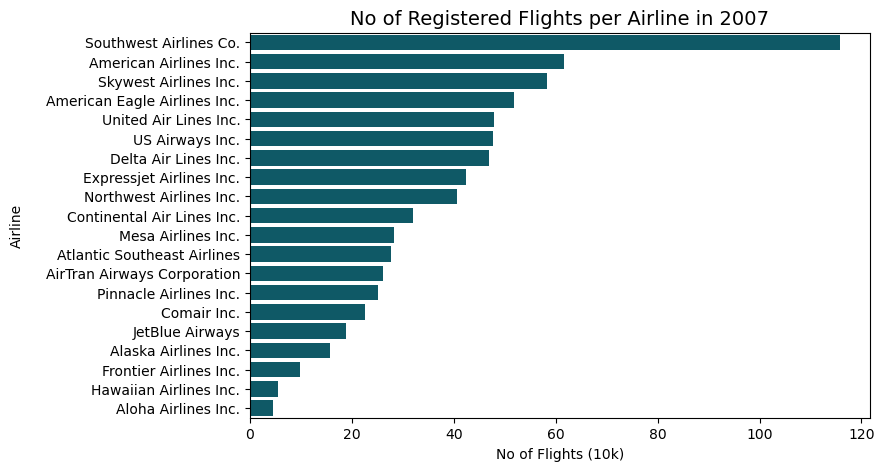

In [21]:
# plot
plt.figure(figsize=[8,5])
sns.barplot(x=(plotdata.Count/10000), y=plotdata.AirlineName,
            color=base_color)
plt.title('No of Registered Flights per Airline in 2007', fontsize=14)
plt.xlabel('No of Flights (10k)')
plt.ylabel('Airline\n')

plt.show();

## What is the distribution of delays for the top airlines?
Airlines with more that 450k registered flights were classified as top airlines. Visualizing by delay group, we can notice that although Southwest Airlines had the most registered flights, it turns out that it has the least on-time or early flights (44%) out of the airlines in the 'more than 450k' group. While Delta Air Lines Inc., which comparatively had the least registered number of flights, turns out to have the most on-time or early flights with a value of 61%.

In [22]:
# get list of flights with more than 450k
more_450 = plotdata.query('Count > 450_000')
more_450 = list(more_450.AirlineName)

In [23]:
# subsetting df
airline_more_450 = airline_df.query('AirlineName in @more_450')

In [24]:
# choosing color palette
colors = sns.color_palette('Set2')[0:5]

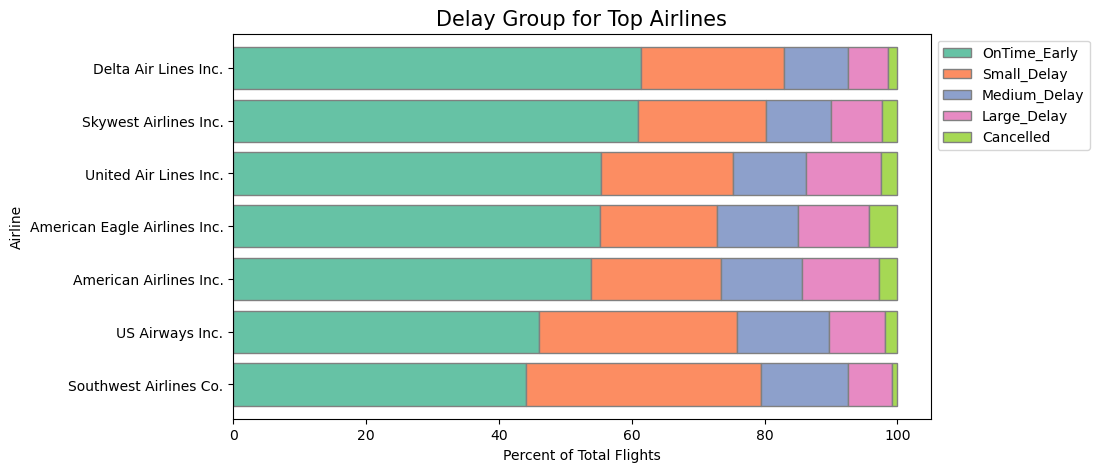

In [25]:
# finding counts of DelayGroup for each airline and normalizing the values.
airline_more_450_agg =  airline_more_450.groupby('AirlineName')['DelayGroup'].value_counts(normalize=True).unstack()

# ordering columns
col_order = ['OnTime_Early', 'Small_Delay', 'Medium_Delay', 'Large_Delay', 'Cancelled']
airline_more_450_agg = airline_more_450_agg[col_order]

# sort by 'OnTime_Early
airline_more_450_agg.sort_values(by='OnTime_Early', ascending=True, inplace=True)

# plot stacked barchart
fig, ax = plt.subplots(figsize=[9,5])
(airline_more_450_agg*100).plot(kind='barh', stacked=True, width=0.8,
                                color=colors, ax=ax, edgecolor='grey')
ax.set_title('Delay Group for Top Airlines', fontsize=15)
ax.set_xlabel('Percent of Total Flights')
ax.set_ylabel('Airline')
ax.legend(bbox_to_anchor=(1,1))

plt.show();

The delay groups were further grouped into 2 groups. 'Good' delays represented the acceptable delays, covering on-time, early and small delay flights while 'Bad' delays covered the medium to Large delays and cancelled flights.

It was seen that Delta Air Lines Inc. has the least bad delays overall while, of the top airlines, American Eagles Airlines Inc has the worst delays.

In [26]:
# create map values
delay_mapping = {
      'OnTime_Early': 'Good', 
      'Small_Delay': 'Good', 
      'Medium_Delay': 'Bad', 
      'Large_Delay': 'Bad',
      'Cancelled': 'Bad'
}

# map values to 'DelayGroup' column
airline_more_450['DelayOK'] = airline_more_450['DelayGroup'].map(delay_mapping)

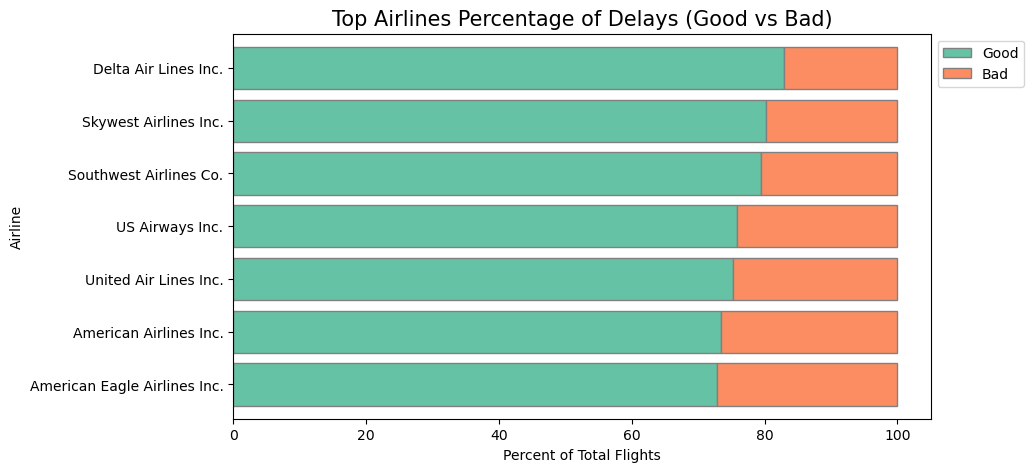

In [27]:
airline_more_450_agg =  airline_more_450.groupby('AirlineName')['DelayOK'].value_counts(normalize=True).unstack()

# ordering columns
airline_more_450_agg = airline_more_450_agg[['Good','Bad']]

# sort by 'OnTime_Early
airline_more_450_agg.sort_values(by='Good', ascending=True, inplace=True)

# plot stacked barchart
fig, ax = plt.subplots(figsize=[9,5])
(airline_more_450_agg*100).plot(kind='barh', stacked=True, width=0.8,
                                color=colors, ax=ax, edgecolor='grey')
ax.set_title('Top Airlines Percentage of Delays (Good vs Bad)', fontsize=15)
ax.set_xlabel('Percent of Total Flights')
ax.set_ylabel('Airline')
ax.legend(bbox_to_anchor=(1,1))

plt.show();

## Key Insights

In 2007, just over 50% of all registered flights were either on-time or early. The remaining approximately 45% were either delayed or outright cancelled. A majority of the delays and cancellations occured from January to mid-April, then from June to August and from the last week of November to December. Southwest Airlines Co. had the most registered flights (1,158,878 flights) but when compared to the top 7 airlines, it had the least percentage of on-time/early flights. 

When looking at acceptable delays (inclusive of on-time/early flights and small delays), both Delta Air Lines Inc and Skywest Airlines inc had the best acceptable delays while both American Airlines and American Eagles Airlines had the worst of the group. 

## Recommendations
* There are still more insights to be drawn from the complete dataset for 1987 to 2008. Tools for working with big data should be employed due to the large size of the combined data.
* Further analysis should look into questions which revolve around;
  * When is the best time of day/day of week/time of year to fly to minimise delays?
  * Do older planes suffer more delays?
  * How does the number of people flying between different locations change over time?
  * How well does weather predict plane delays?
  * Can you detect cascading failures as delays in one airport create delays in others? Are there critical links in the system?

## References
[Data Expo 2009: Airline On time data, ASA Statistical Computing Dataverse, Havard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/HG7NV7)

In [1]:
!jupyter nbconvert slide_deck.ipynb --to slides --post serve --no-input --no-prompt